In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

%config InlineBackend.figure_format = 'retina'

In [2]:
B=250
n_p=250 #number of simulations used to estimate power
alpha=.05
perc=list(range(20,100,20)) #percentiles for binning
n = 5000
lamb = .1
task='reg'
test=.5

## Cov. shift (ours)

In [3]:
def GenNoise(n,d):
    data=pd.DataFrame(np.random.normal(0,1,(d-1)*n).reshape((n,d-1)))
    data.columns=['x'+str(i) for i in range(1,data.shape[1]+1)]
    return data

In [4]:
pvals_ours=[]

d_ours=[1,2,3,4, 10,20,30,40, 100,200,300,400]

for d in d_ours:
    for k in tqdm(range(n_p)):
        for theta in [0]:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, _, _, _, _, \
            Xt_train, Xt_test, _, _, _, _ = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)
            n_train=int((1-test)*n)
            Xs_train=pd.concat([Xs_train.reset_index(drop=True), GenNoise(n_train,d).reset_index(drop=True)], axis=1)
            Xt_train=pd.concat([Xt_train.reset_index(drop=True), GenNoise(n_train,d).reset_index(drop=True)], axis=1)
            n_test=int(test*n)
            Xs_test=pd.concat([Xs_test.reset_index(drop=True), GenNoise(n_test,d).reset_index(drop=True)], axis=1)
            Xt_test=pd.concat([Xt_test.reset_index(drop=True), GenNoise(n_test,d).reset_index(drop=True)], axis=1)
            
            ### P-values ###
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)
            cov=Permut(Xs_test, Xt_test, covshift_model, B=B, verbose=False)
            pval_kl = cov['pval']
            pvals_ours.append([d,pval_kl])
            
pvals_ours=np.array(pvals_ours)

100%|██████████| 250/250 [01:21<00:00,  3.06it/s]


In [5]:
power_ours=[]

for d in d_ours:   
    ind=pvals_ours[:,0]==d
    power_ours.append([d,np.mean(pvals_ours[ind,1]<alpha)])
    
power_ours=np.array(power_ours)

In [6]:
power_ours

array([[1.00e+00, 9.52e-01],
       [2.00e+00, 9.28e-01],
       [3.00e+00, 8.92e-01],
       [4.00e+00, 8.92e-01],
       [1.00e+01, 8.36e-01],
       [2.00e+01, 6.80e-01],
       [3.00e+01, 5.72e-01],
       [4.00e+01, 4.88e-01],
       [1.00e+02, 3.40e-01],
       [2.00e+02, 2.44e-01],
       [3.00e+02, 1.64e-01],
       [4.00e+02, 1.80e-01]])

In [7]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.05   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

## Cov. shift (TV)

In [8]:
pvals_tv=[]

d_tv=[1,2,3,4]

for d in d_tv:
    for k in tqdm(range(n_p)):
        for theta in [0]:
                
            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs=np.hstack((Xs,np.array(GenNoise(n,d)))) 
            Xt=np.hstack((Xt,np.array(GenNoise(n,d))))
            Xbins = np.percentile(np.vstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)

            #Xs
            df = pd.DataFrame(Xs_bin, dtype='str')
            if d==1:
                df['concat'] = df[0]
            elif d==2:
                df['concat'] = df[0]+df[1]
            elif d==3:
                df['concat'] = df[0]+df[1]+df[2]
            elif d==4:
                df['concat'] = df[0]+df[1]+df[2]+df[3]
 
            Xs_bin=np.array(df['concat'], dtype='int')

            #Xt
            df = pd.DataFrame(Xt_bin, dtype='str')
            if d==1:
                df['concat'] = df[0]
            elif d==2:
                df['concat'] = df[0]+df[1]
            elif d==3:
                df['concat'] = df[0]+df[1]+df[2]
            elif d==4:
                df['concat'] = df[0]+df[1]+df[2]+df[3]

            Xt_bin=np.array(df['concat'], dtype='int')

            ### P-values ###
            covshift=tv(Xs_bin,Xt_bin)
            X_bin = np.hstack((Xs_bin,Xt_bin))
                
            covperm = []
            for b in range(B):
                shuffle = np.random.choice(range(X_bin.shape[0]), size=(X_bin.shape[0],), replace=False)
                inds = shuffle[:Xs_bin.shape[0]]
                indt = shuffle[Xs_bin.shape[0]:]
                covperm.append(tv(X_bin[inds],X_bin[indt]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            covperm=np.array(covperm)
            covperm=covperm+np.random.normal(0,s,covperm.shape[0])
            covshift=covshift+np.random.normal(0,s,1)

            pval_tv=(1+np.sum(np.array(covperm) >= covshift))/(B+1)
                
            #Output
            pvals_tv.append([d,pval_tv])
                
            #print(np.unique(X_bin).shape[0])
    
pvals_tv=np.array(pvals_tv)

100%|██████████| 250/250 [21:40<00:00,  5.20s/it]


In [9]:
power_tv=[]

for d in d_tv:   
    ind=pvals_tv[:,0]==d
    power_tv.append([d,np.mean(pvals_tv[ind,1]<alpha)])
    
power_tv=np.array(power_tv)

In [10]:
power_tv

array([[1.   , 0.984],
       [2.   , 0.744],
       [3.   , 0.316],
       [4.   , 0.176]])

## Plots

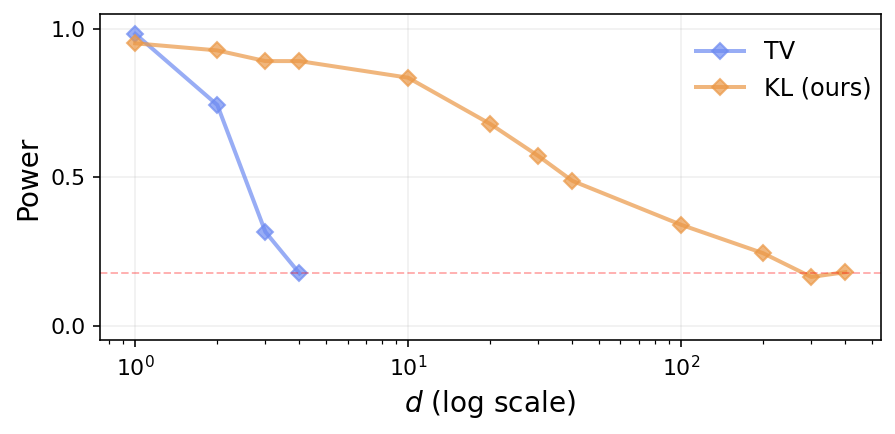

In [36]:
plt.figure(figsize=(7,3))

names=["TV", "KL (ours)"] 
colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080'] 

plt.plot([d for d in d_tv], power_tv[:,1], color=colors[4], marker="D", lw=2, label=names[0], alpha=.7, markersize=6)
plt.plot([d for d in d_ours], power_ours[:,1], color=colors[3], marker="D", lw=2, label=names[1], alpha=.7, markersize=6)
plt.xscale('log')

plt.legend(bbox_to_anchor=(1, .95), loc='upper right', ncol = 1, prop={'size': 12}, borderaxespad=.0, frameon=False)       
plt.grid(alpha=.2)
plt.axhline(y=power_tv[-1,1], color='r', linestyle='--', lw=1, alpha=.3)
plt.ylabel('Power', size=14)
plt.ylim([-0.05,1.05])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("$d$ (log scale)", size=14)
plt.locator_params(axis="y", nbins=4)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
plt.savefig('plots/dimensions.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()